## Experiment

In [1]:
experiment_label = 'rforest01'

### Aim:
* compare basic random forest to best logreg

### Findings:

* ROC on training hugs the top left; overfitting.
* Next: increase min samples per leaf. 

## Set up

In [2]:
import pandas as pd
import numpy as np
from joblib import dump, load  # simpler than pickle!
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [3]:
#load data

data_path = '../data/raw/uts-advdsi-nba-career-prediction'

train_raw = pd.read_csv(data_path + '/train.csv')
test_raw = pd.read_csv(data_path + '/test.csv')


In [4]:
#shapes & head

print(train_raw.shape)
print(test_raw.shape)

train_raw.head()

(8000, 22)
(3799, 21)


,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [5]:
test_raw.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [6]:
# info
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
Id_old         8000 non-null int64
Id             8000 non-null int64
GP             8000 non-null int64
MIN            8000 non-null float64
PTS            8000 non-null float64
FGM            8000 non-null float64
FGA            8000 non-null float64
FG%            8000 non-null float64
3P Made        8000 non-null float64
3PA            8000 non-null float64
3P%            8000 non-null float64
FTM            8000 non-null float64
FTA            8000 non-null float64
FT%            8000 non-null float64
OREB           8000 non-null float64
DREB           8000 non-null float64
REB            8000 non-null float64
AST            8000 non-null float64
STL            8000 non-null float64
BLK            8000 non-null float64
TOV            8000 non-null float64
TARGET_5Yrs    8000 non-null int64
dtypes: float64(18), int64(4)
memory usage: 1.3 MB


In [7]:
#variable descriptions
train_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,...,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [8]:
test_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,...,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,...,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,...,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,...,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,...,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,...,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,...,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,...,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


## Cleaning

In [9]:
train = train_raw.copy()
test = test_raw.copy()

In [10]:
cols_drop = ['Id_old', 'Id'] #, 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

In [11]:
train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [12]:
test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [13]:
train_target = train.pop('TARGET_5Yrs')

# Modelling

In [14]:
#transformations

# fit scaler to training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train = scaler.fit_transform(train)
dump(scaler, '../models/aj_' + experiment_label + '_scaler.joblib')

# transform test data
test = scaler.transform(test)

In [15]:
#examine shapes

print('train:' + str(train.shape))
print('test:' + str(test.shape))

train:(8000, 19)
test:(3799, 19)


In [16]:
# split training into train & validation

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)

# in this case we will use the Kaggle submission as our test
#X_train, y_train = train, train_target

In [17]:
#import models

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


In [19]:
# Define model

model = RandomForestClassifier(class_weight='balanced',random_state=8)


In [20]:
#fit model to training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [21]:
#save model to file

dump(model,  '../models/aj_' + experiment_label + '.joblib')

['../models/aj_rforest01.joblib']

In [22]:
#predictions for test and validation sets

y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

## Evaluation

In [23]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.models.aj_metrics import confusion_matrix


ModuleNotFoundError: No module named 'src.models.aj_metrics'

In [ ]:
print("Training:")
print(confusion_matrix(y_train, y_train_preds))
print('')
print("Validation:")
print(confusion_matrix(y_val, y_val_preds))

In [25]:
from sklearn import metrics

print("Training:")
print(metrics.classification_report(y_train, y_train_preds))
print('')
print("Validation:")
print(metrics.classification_report(y_val, y_val_preds))


Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1074
           1       1.00      1.00      1.00      5326

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400


Validation:
              precision    recall  f1-score   support

           0       0.35      0.03      0.05       257
           1       0.84      0.99      0.91      1343

    accuracy                           0.84      1600
   macro avg       0.60      0.51      0.48      1600
weighted avg       0.76      0.84      0.77      1600



In [26]:
print("Training:")
print(metrics.roc_auc_score(y_train, model.decision_function(X_train)))
print('')
print("Validation:")
print(metrics.roc_auc_score(y_val, model.decision_function(X_val)))

Training:


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

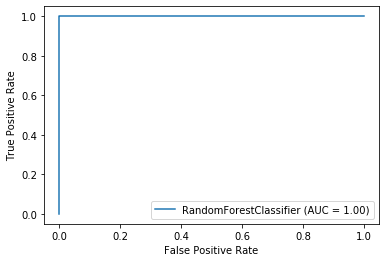

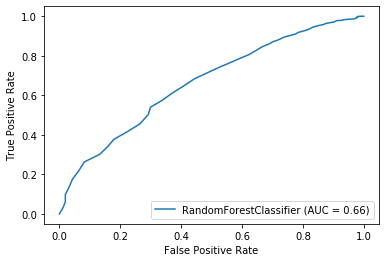

In [27]:
import matplotlib.pyplot as plt  
from sklearn import metrics
metrics.plot_roc_curve(model, X_train, y_train)
plt.show() 
metrics.plot_roc_curve(model, X_val, y_val)
plt.show() 

# Apply to test data for submission

In [ ]:
y_test_preds = model.predict(test)


In [ ]:
y_test_preds

In [ ]:
y_test_probs = model.predict_proba(test)

In [ ]:
y_test_probs

In [ ]:
len(y_test_probs)

In [ ]:
test_raw.shape

In [ ]:
test_raw['Id'].shape

In [ ]:
submission = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p[1] for p in y_test_probs]})

In [ ]:
submission.head()

In [ ]:
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',
                 index=False,
                 )